Based on the main EBUS extraction script but to work with remapped to POP stuff, like SST or landschuetzer data.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def detect_EBUS(x):
    # Will return latitude and longitude boundings for the selected region.
    # x should be a string from the following:
        # CalCS : California Current
        # BenCS : Benguela Current
        # CanCS : Canary Current
        # HumCS : Humboldt Current
    if x == "CalCS":
        lat1 = 25
        lat2 = 46
        lon1 = 215
        lon2 = 260
    elif x == "BenCS":
        lat1 = -30
        lat2 = -16
        lon1 = 0
        lon2 = 20
    elif x == "CanCS":
        lat1 = 19 
        lat2 = 33 
        lon1 = 330
        lon2 = 359
    elif x == "HumCS":
        lat1 = -20
        lat2 = 0
        lon1 = 260
        lon2 = 290
    else:
        raise ValueError('\n' + 'Must select from the following EBUS strings:'
                         + '\n' + 'CalCS' + '\n' + 'CanCS' + '\n' + 'BenCS' +
                         '\n' + 'HumCS')
    return lat1, lat2, lon1, lon2

In [3]:
def find_indices(latGrid, lonGrid, latPoint, lonPoint):
    dx = lonGrid - lonPoint
    dy = latGrid - latPoint
    reducedGrid = abs(dx) + abs(dy)
    min_ix = np.nanargmin(reducedGrid)
    i, j = np.unravel_index(min_ix, reducedGrid.shape)
    return i, j

# SCRIPT

In [52]:
EBC = 'BenCS'

In [53]:
fileName = '/glade/u/home/rbrady/work/Landschuetzer_pCO2/SST.reynolds.1982-2015.POP.masked.nc'
ds = xr.open_dataset(fileName)
ds.attrs = ''
ds = ds['SST']

In [54]:
# Append on POP variables
pop = xr.open_dataset('/glade/u/home/rbrady/scratch/EBUS_BGC_Variability/SST_monthly/SST.001.192001-210012.nc',
                      decode_times=False)
ds['REGION_MASK'] = pop['REGION_MASK']
ds['DXT'] = pop['DXT']
ds['TLAT'] = pop['TLAT']
ds['TLONG'] = pop['TLONG']
ds['TAREA'] = pop['TAREA']
ds['TAREA'] = ds['TAREA'] / (100 * 100)

In [55]:
if EBC == "BenCS":
    lon = np.asarray(ds['TLONG'])
    mask = (lon > 180)
    lon[mask] = lon[mask] - 360
    ds['TLONG'] = (('nlat','nlon'), lon) # Now -180 to 180 range.

In [56]:
lat1, lat2, lon1, lon2 = detect_EBUS(EBC)
a, c = find_indices(ds['TLAT'].values, ds['TLONG'].values, lat1, lon1)
b, d = find_indices(ds['TLAT'].values, ds['TLONG'].values, lat2, lon2)
ds = ds.isel(nlat=slice(a,b), nlon=slice(c,d))

In [57]:
# Remask 
#ds = ds.where(ds !=0, np.nan)

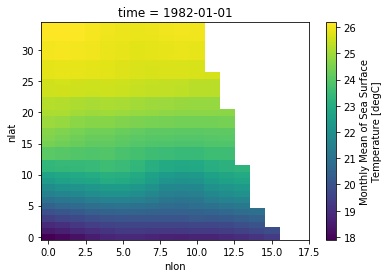

In [58]:
ds.isel(time=0).plot()

In [59]:
ds.to_netcdf('/glade/work/rbrady/EBUS_BGC_Variability/Reynolds_Extracted/' + 
             'Reynolds.' + EBC + '.1982-2015.nc')

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
